In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nnfs
from nnfs.datasets import spiral_data
from NNS import NeuralNetwork as NN #import neural net code from github to reduce copy/pasting

from sklearn.neighbors import KNeighborsClassifier


# L1 and L2 Regularization

In [ ]:
#Edit Dense Layer to include regularizers
class Layer_Dense: #Completely Random Dense Layer
    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1 = 0 , weight_regularizer_l2 = 0 ,
                 bias_regularizer_l1 = 0 , bias_regularizer_l2 = 0 ):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons) #initialize weights
        #Note: Multiplied by 0.01 since it is often better to have start weights that minimally affect the training
        self.biases = np.zeros((1, n_neurons)) # initialize biases to 0
        #Note: initial bias for 0 is common to ensure neuron fires 
        
        # Set regularization strength (lambdas)
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    #Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
        
    #Backward Pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradient on vregularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0 ] = - 1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0 :
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0 :
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0 ] = - 1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0 :
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases
        
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        
class Loss:
    def calculate(self, output, y):
        #calculate sample losses
        sample_losses = self.forward(output,y)
        # Calculate mean loss
        data_loss = np.mean(sample_losses)
        
        return data_loss
    
    # Regularization loss calculation
    def regularization_loss(self, layer):
        
        # 0 by default
        regularization_loss = 0
        
        # L1 regularization - weights
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        
        # L2 regularization - weights
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)
            
        # L1 regularization - biases
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))
            
        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
        
        return regularization_loss
    

In [ ]:
X, y = spiral_data(samples=1000, classes=3)

dense1 = Layer_Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)

activation1 = NN.Activation_ReLU()

dense2 = Layer_Dense(64,3)

loss_activation = NN.Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = NN.Optimizer_Adam(learning_rate=0.2, decay=5e-7)

for epoch in range(10001):
    
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    
    data_loss = loss_activation.forward(dense2.output, y)
    
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    
    loss = data_loss + regularization_loss
    
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    if not epoch % 1000:
        print(  f'epoch: {epoch}, ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f}), ' +
                f'lr: {optimizer.current_learning_rate}, ' +
                f'validation, acc: {accuracy :.3f} , loss: {loss :.3f} ')
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.315 , loss: 1.099 (data_loss: 1.099 , reg_loss: 0.000), lr: 0.2, validation, acc: 0.315 , loss: 1.099 
epoch: 1000, acc: 0.860 , loss: 0.397 (data_loss: 0.378 , reg_loss: 0.019), lr: 0.19990014987513738, validation, acc: 0.860 , loss: 0.397 
epoch: 2000, acc: 0.871 , loss: 0.382 (data_loss: 0.334 , reg_loss: 0.048), lr: 0.19980029960054924, validation, acc: 0.871 , loss: 0.382 
epoch: 3000, acc: 0.866 , loss: 0.355 (data_loss: 0.331 , reg_loss: 0.023), lr: 0.19970054902673443, validation, acc: 0.866 , loss: 0.355 
epoch: 4000, acc: 0.858 , loss: 0.378 (data_loss: 0.364 , reg_loss: 0.014), lr: 0.19960089800444014, validation, acc: 0.858 , loss: 0.378 
epoch: 5000, acc: 0.851 , loss: 0.404 (data_loss: 0.366 , reg_loss: 0.038), lr: 0.1995013463847114, validation, acc: 0.851 , loss: 0.404 
epoch: 6000, acc: 0.838 , loss: 0.452 (data_loss: 0.403 , reg_loss: 0.049), lr: 0.19940189401889033, validation, acc: 0.838 , loss: 0.452 
epoch: 7000, acc: 0.831 , loss: 0.460 (data_los

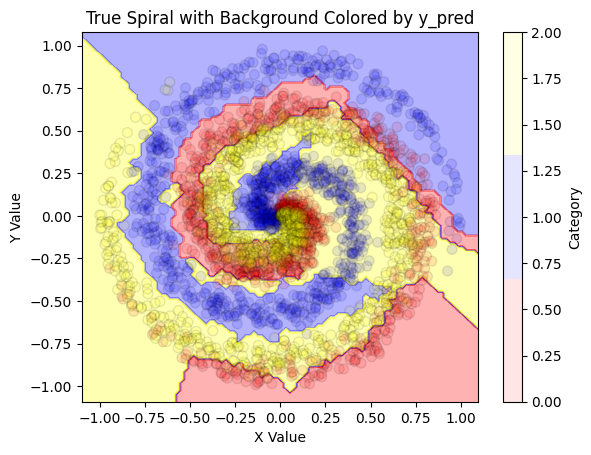

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#  Create a meshgrid for the plot background
x_min, x_max = X[:, 0].min() -0.1 , X[:, 0].max() +0.1
y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() +0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Step 2: Predict the category for each point in the meshgrid based off of y_pred
# Using the nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, predictions)

# Predict categories for the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions back to the grid shape
Z = Z.reshape(xx.shape)

# Create the background color plot
cmap = ListedColormap(['red', 'blue', 'yellow'])  # Assign colors for each category
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)  # Fill the regions with color

# Plot the scatter plot, 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha = 0.1)

# Add color bar to indicate values of y_pred
plt.colorbar(label='Category')

# Add labels and title
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.title('True Spiral with Background Colored by y_pred')

# Show the plot
plt.show()


Quite a bit better, but let's try with more neurons

epoch: 0, acc: 0.298 , loss: 1.099 (data_loss: 1.099 , reg_loss: 0.000), lr: 0.2, validation, acc: 0.298 , loss: 1.099 
epoch: 1000, acc: 0.851 , loss: 0.414 (data_loss: 0.363 , reg_loss: 0.051), lr: 0.19990014987513738, validation, acc: 0.851 , loss: 0.414 
epoch: 2000, acc: 0.875 , loss: 0.477 (data_loss: 0.321 , reg_loss: 0.156), lr: 0.19980029960054924, validation, acc: 0.875 , loss: 0.477 
epoch: 3000, acc: 0.864 , loss: 0.523 (data_loss: 0.360 , reg_loss: 0.163), lr: 0.19970054902673443, validation, acc: 0.864 , loss: 0.523 
epoch: 4000, acc: 0.850 , loss: 0.591 (data_loss: 0.410 , reg_loss: 0.181), lr: 0.19960089800444014, validation, acc: 0.850 , loss: 0.591 
epoch: 5000, acc: 0.857 , loss: 0.512 (data_loss: 0.361 , reg_loss: 0.151), lr: 0.1995013463847114, validation, acc: 0.857 , loss: 0.512 
epoch: 6000, acc: 0.853 , loss: 0.487 (data_loss: 0.353 , reg_loss: 0.134), lr: 0.19940189401889033, validation, acc: 0.853 , loss: 0.487 
epoch: 7000, acc: 0.720 , loss: 0.970 (data_los

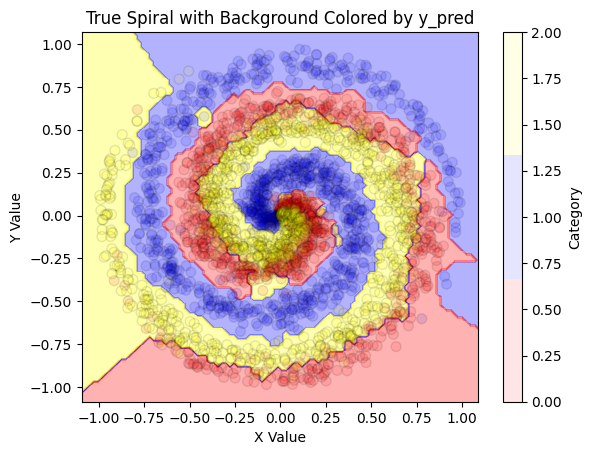

In [30]:
X, y = spiral_data(samples=1000, classes=3)

dense1 = Layer_Dense(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)

activation1 = NN.Activation_ReLU()

dense2 = Layer_Dense(512,3)

loss_activation = NN.Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = NN.Optimizer_Adam(learning_rate=0.2, decay=5e-7)

for epoch in range(10001):
    
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    
    data_loss = loss_activation.forward(dense2.output, y)
    
    regularization_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)
    
    loss = data_loss + regularization_loss
    
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)
    
    if not epoch % 1000:
        print(  f'epoch: {epoch}, ' +
                f'acc: {accuracy :.3f} , ' +
                f'loss: {loss :.3f} (' +
                f'data_loss: {data_loss :.3f} , ' +
                f'reg_loss: {regularization_loss :.3f}), ' +
                f'lr: {optimizer.current_learning_rate}, ' +
                f'validation, acc: {accuracy :.3f} , loss: {loss :.3f} ')
        
    
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    

#  Create a meshgrid for the plot background
x_min, x_max = X[:, 0].min() -0.1 , X[:, 0].max() +0.1
y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() +0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Step 2: Predict the category for each point in the meshgrid based off of y_pred
# Using the nearest neighbors

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, predictions)

# Predict categories for the meshgrid points
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape the predictions back to the grid shape
Z = Z.reshape(xx.shape)

# Create the background color plot
cmap = ListedColormap(['red', 'blue', 'yellow'])  # Assign colors for each category
plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)  # Fill the regions with color

# Plot the scatter plot, 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50, alpha=0.1)

# Add color bar to indicate values of y_pred
plt.colorbar(label='Category')

# Add labels and title
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.title('True Spiral with Background Colored by y_pred')

# Show the plot
plt.show()
